# CSE 152A Fall 2022 – Assignment 2


- Assignment Published On: **Mon, Oct 17, 2022**

- Due On: **Sat, Oct 29, 2022 11:59 PM (Pacific Time)**



In [4]:
# Setup
import numpy as np
from time import time
from skimage import io
%matplotlib inline
import matplotlib.pyplot as plt

## Problem 1: Edge & Cornder Detection [23 pts]

### Problem 1.1: Edge Detection [8 pts]

In this problem, you will write a function to perform edge detection. The following steps need to be implemented.

- **Smoothing [2 pt]:** First, we need to smooth the images to prevent noise from being considered edges. For this problem, use a 9x9 Gaussian kernel filter with $\sigma = 1.4$ to smooth the images.

- **Gradient Computation [3+3 pts]:** After you have finished smoothing, find the image gradient in the horizontal and vertical directions. Compute the gradient magnitude image as $|G| = \sqrt{G_x^2 + G_y^2}$  and gradient direction as $tan^{-1}(G_y/G_x)$.

Compute the images after each step. Show each of the intermediate steps and label your images accordingly.

In total, there should be four output images (original, smoothed, gradient magnitude, gradient direction).

**For this question, use the image `geisel.jpeg`.**

Original:


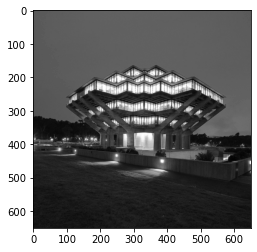

Smoothed:


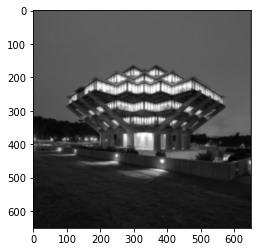

Gradient magnitude:


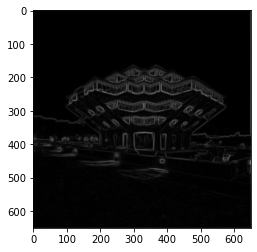

Gradient direction:


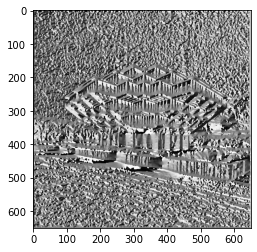

In [5]:
import numpy as np
from skimage import io
from collections import defaultdict
from scipy.signal import convolve
import matplotlib.pyplot as plt
%matplotlib inline

def gaussian2d(filter_size=9, sig=1.0):
    """
    Creates 2D Gaussian kernel with side length `filter_size` and a sigma of `sig`.
    Source: https://stackoverflow.com/a/43346070
    """
    ax = np.arange(-filter_size // 2 + 1., filter_size // 2 + 1.)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sig))
    return kernel / np.sum(kernel)


def smooth(image):
    smooth_image = np.zeros_like(image)
    
    ### YOUR CODE HERE
    
    kernel = gaussian2d(9,1.4)

    #print(image.shape)

    #image is 650x650
    #smooth_image is 650x650
    #kernel is 9x9

    #Are we not supposed to matmul these two things?


    smooth_image = convolve(image, kernel, mode="same")
    
    ### END YOUR CODE HERE
    
    return smooth_image

def gradient(image):

    g_mag = np.zeros_like(image)
    g_theta = np.zeros_like(image)

    gx = np.array([[-1/2,0,1/2], [-1/2,0,1/2], [-1/2,0,1/2]])
    gy = np.array([[-1/2,-1/2,-1/2], [0,0,0], [1/2,1/2,1/2]])


    dz_over_dx = convolve(image, gx, mode="same")
    dz_over_dy = convolve(image, gy, mode="same")
    
    ### YOUR CODE HERE
    
    for x in range(0,len(image)):
        for y in range(0, len(image[0])):
            
            gradient_vector = np.array([dz_over_dx[x][y],dz_over_dy[x][y]])

            add_square = np.square(gradient_vector[0]) + np.square(gradient_vector[1])

            g_mag[x][y] = np.sqrt(add_square)
            g_theta[x][y] = np.arctan2(gradient_vector[0],gradient_vector[1])

    ### END YOUR CODE
     
    
    return g_mag, g_theta

def edge_detect(image):
    """Perform edge detection on the image."""
    smoothed = smooth(image)
    g_mag, g_theta = gradient(smoothed)
    return smoothed, g_mag, g_theta



# Load image in grayscale
image = io.imread('geisel.jpeg', as_gray=True)
smoothed, g_mag, g_theta = edge_detect(image)



print('Original:')
plt.imshow(image, cmap='gray')
plt.show()

print('Smoothed:')
plt.imshow(smoothed, cmap='gray')
plt.show()

print('Gradient magnitude:')
plt.imshow(g_mag, cmap='gray')
plt.show()

print('Gradient direction:')
plt.imshow(g_theta, cmap='gray')
plt.show()


### Problem 1.2: Corner Detection [15 pts]

Next, you will implement a corner detector to detect photo-identifiable features in the image.

This should be done according to the easier method of looking at regions with significant value of the minimum eigenvalue. You should fill in the function <code>corner_detect</code> with inputs <code>image, nCorners, smoothSTD, windowSize</code>, where smoothSTD is the standard deviation of the smoothing kernel and windowSize is the window size for Gaussian smoothing, corner detection and non-maximum suppression. Instead of using a hard threshold, return the nCorners strongest corners after non-maximum suppression. This way you can control exactly how many corners are returned. Your function should also return the matrix of minimum eigen values that you computed.

For each image, detect 100 corners with a Gaussian standard deviation of 2.0 and a window size of 13. Display the corners using the show_corners_result function and plot the minimum eigen value images using the show_eigen_images function.

**For this question, we will use images `almond0.jpg` and `almond1.jpg`.**

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import imageio

In [7]:
def rgb2gray(rgb):
    """ Convert rgb image to grayscale.
    """
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

In [8]:
def smooth2(image, smoothSTD):

    smooth_image = np.zeros_like(image)
    kernel = gaussian2d(9,smoothSTD)

    smooth_image = convolve(image, kernel, mode="same")
    return smooth_image


def gradient2(image):

    g_x = np.zeros_like(image)
    g_y = np.zeros_like(image)
    #gradient_mat = np.dstack((g_x,g_y)) #300x650x2
    #print(gradient_mat.shape)

    gx = np.array([[-1/2,0,1/2], [-1/2,0,1/2], [-1/2,0,1/2]])
    gy = np.array([[-1/2,-1/2,-1/2], [0,0,0], [1/2,1/2,1/2]])


    dz_over_dx = convolve(image, gx, mode="same")
    dz_over_dy = convolve(image, gy, mode="same")
    
    ### YOUR CODE HERE
    
    for x in range(0,len(image)):
        for y in range(0, len(image[0])):
            
            gradient_vector = np.array([dz_over_dx[x][y],dz_over_dy[x][y]])

            g_x[x][y] = gradient_vector[0]
            g_y[x][y] = gradient_vector[1]

    return g_x, g_y



In [9]:
import math
import operator
import itertools
from collections import OrderedDict

def corner_detect(image, nCorners, smoothSTD, windowSize):
    """Detect corners on a given image.

    Args:
        image: Given a grayscale image on which to detect corners.
        nCorners: Total number of corners to be extracted.
        smoothSTD: Standard deviation of the Gaussian smoothing kernel.
        windowSize: Window size for Gaussian smoothing kernel, corner detector, and non maximum suppression.

    Returns:
        Detected corners (in image coordinate) in a numpy array (n*2).
        The minor eigen value image having the same shape as the image
    """

    # From discussion: "Smooth the image before edge or corner detection"
    image_s = smooth2(image,smoothSTD)

    #get gradients:
    gradients_x, gradients_y = gradient2(image_s) #image_s is 300x650

    corners = np.zeros((nCorners, 2))  #in use case: 100 x 2
    minor_eig_image = np.zeros_like(image) #corner response image in use case: 300x650, screw padding
    offset = math.floor(windowSize/2)  #offset to find the center pixel of that window


    #a window that moves horizontally first, then vertically
    for x in range(offset, image_s.shape[0]): #moves the x-component of the center pixel
        for y in range(offset, image_s.shape[1]): #moves the y-component of the center pixel

            x_start = x - offset  #ok
            x_end = x + offset + 1
            y_start = y - offset  #ok
            y_end = y + offset + 1

            window_x = gradients_x[x_start:x_end, y_start:y_end] 
            window_y = gradients_y[x_start:x_end, y_start:y_end]

            c = np.zeros((2,2))

            x_square = window_x**2
            x_y = window_x * window_y
            y_square = window_y**2
            
            val00 = np.sum(x_square)
            val01 = np.sum(x_y)
            val10 = np.sum(x_y)
            val11 = np.sum(y_square)

            c[0,0] = val00
            c[0,1] = val01
            c[1,0] = val10
            c[1,1] = val11

            eigenvalues = np.linalg.eigvals(c) #should return a 2x1 vector

            minor_eigenval = min(eigenvalues[0], eigenvalues[1])
            minor_eig_image[x,y] = minor_eigenval

    #print("Minor eig image: ")
    #plt.imshow(minor_eig_image, cmap="jet") 


    #NON_MAXIMUM SUPRESSION:

    corner_keys = []
    corner_values = []

    #a window that moves horizontally first, then vertically
    for x in range(offset, image_s.shape[0]): #moves the x-component of the center pixel
        for y in range(offset, image_s.shape[1]): #moves the y-component of the center pixel

            x_start = x - offset  #ok
            x_end = x + offset + 1
            y_start = y - offset  #ok
            y_end = y + offset + 1

            window = minor_eig_image[x_start:x_end, y_start:y_end] 

            max_val = np.max(window)

            if(max_val == minor_eig_image[x,y]):

                coordinates = (x,y)
                corner_keys.append(max_val)
                corner_values.append(coordinates)
                #corner_cans.setdefault({max_val:coordinates})

    corner_cans = {corner_keys[i]: corner_values[i] for i in range(len(corner_keys))}

    #Sort the corners by increasing value:
    sorted_corns = OrderedDict(sorted(corner_cans.items()))
    sorted_corns = OrderedDict(reversed(sorted_corns.items()))
    top_corns = dict(itertools.islice(sorted_corns.items(), 100))

    #each corner has an x-coordinate and a y-coordinate
    
    for i in range(0, len(top_corns)):

        curr_tuple = list(top_corns.values())[i]

        corners[i,0] = curr_tuple[0]
        corners[i,1] = curr_tuple[1]

    #print(image.shape)
    #print(nCorners.shape)
    #print(smoothSTD.shape) #willing to bet it's a scalar
    #print(windowSize.shape) #willing to bet it's a scalar or vector
    #print(np.max(minor_eig_image))
    
    return corners, minor_eig_image

    

In [10]:
def show_eigen_images(imgs):
    print("Minor Eigen value images")
    fig = plt.figure(figsize=(16, 16))
    # Plot image 1
    plt.subplot(1,2,1)
    plt.imshow(imgs[0], cmap='jet')
    plt.title('almond 1')

    # Plot image 2
    plt.subplot(1,2,2)
    plt.imshow(imgs[1], cmap='jet')
    plt.title('almond 2')
    
    plt.show()
    
def show_corners_result(imgs, corners):
    print("Detected Corners")
    fig = plt.figure(figsize=(16, 16))
    ax1 = fig.add_subplot(221)
    ax1.imshow(imgs[0], cmap='gray')
    ax1.scatter(corners[0][:, 1], corners[0][:, 0], s=35, edgecolors='r', facecolors='none')

    ax2 = fig.add_subplot(222)
    ax2.imshow(imgs[1], cmap='gray')
    ax2.scatter(corners[1][:, 1], corners[1][:, 0], s=35, edgecolors='r', facecolors='none')
    plt.show()

In [11]:
# detect corners on the two provided images
# adjust your corner detection parameters here
nCorners = 100
smoothSTD = 2
windowSize = 13

# read images and detect corners on images
imgs = []
eig_imgs = []
corners = []
for i in range(2):
    img = io.imread('almond' + str(i) + '.jpg')
    imgs.append(rgb2gray(img))

    #print(imgs[-1].shape) #300x650

    #gradient2(smooth2(imgs[-1],smoothSTD))


    corners_vals, minor_eig_image = corner_detect(imgs[-1], nCorners, smoothSTD, windowSize)
    eig_imgs.append(minor_eig_image)
    corners.append(corners_vals)

Minor Eigen value images


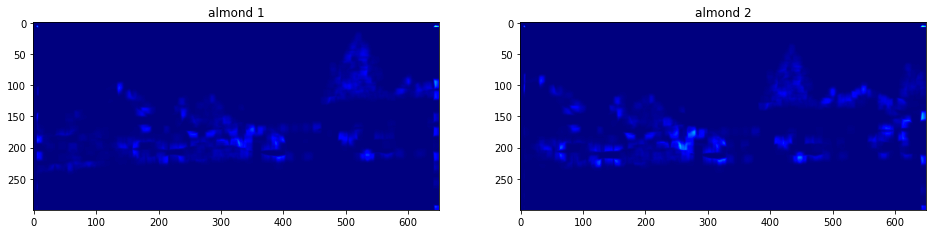

Detected Corners


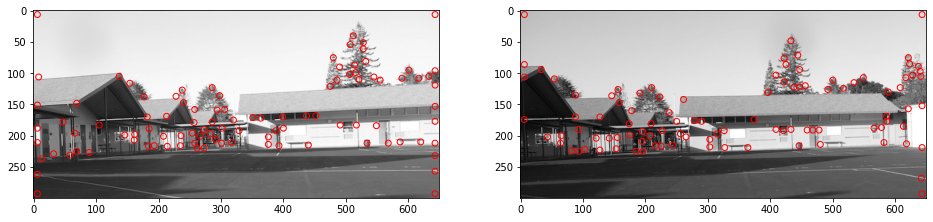

In [12]:
show_eigen_images(eig_imgs)
show_corners_result(imgs, corners)

## Problem 2: Theory [20 points]
### Problem 2.1: Epipolar Geometry [10 points]

Consider two cameras whose image planes are the z=2 plane, and whose focal points are at (-6, 0, 0) and (6, 0, 0). See Fig 1.1 below. We'll call a point in the first camera (x, y), and a point in the second camera (u, v). Points in each camera are relative to the camera center. So, for example if (x, y) = (0, 0), this is really the point (-6, 0, 2) in world coordinates, while if (u, v) = (0, 0) this is the point (6, 0, 2).

![fig 1.1](fig/fig1.png)

Suppose the point (x, y) = (3, 3) is matched to the point (u, v) = (2, 3). What is the 3D location of this point?

The focal point of camera 1 and (x,y) (which is (-3,3,2) in the real world plane) intersect on a line r(t1) = <-6,0,0> + t1<3,3,2> where t1 is a scaling factor of the difference vector <3,3,2>.

The focal point of camera 2 and (u,v) (which is (8,3,2) in the real world plane) intersect on a line s(t2) = <-6,0,0> + t2<2,3,2> where t2 is a scaling factor of the difference vector <2,3,2>.

Since the point whose image appears in (x,y) and (u,v) must be the point of intersection of r(t1) and s(t2), we can set the x, y and z components of each equation equal to each other and solve for the necessary scaling factors to compute this point. We end up with the following:

            -6 + 3t1 = 6 + 2t2 (eqn1)
                 3t1 = 3t2     (eqn2)
                 2t1 = 2t2     (eqn3)

Subracting eqn2 from eqn1 results in t2 = 12 and plugging this back into eqn1 results in t1 = 12.
Plugging these two values into eqn3 ensures that our lines are not skew (2(12) = 2(12)) and therefore we have ensured that our lines intersect.

To find the point of intersection we can solve for r(12) or s(12). Either equation gives <30, 36, 24> as the location of our point.

### Problem 2.2: The Epipolar Constraint [5 points]

Suppose two cameras fixate on a point $P$ in space such that their principal axes intersect at that point. (See the fig. 1.2 below.) Show that if the image coordinates are normalized so that the coordinate origin (0, 0) coincides with the principal point, then the $F_{33}$ element of the fundamental matrix is zero.

![fig 1.2](fig/ec_diagram.png)

In the figure, $C1$ and $C2$ are the optical centers. The principal axes intersect at point $P$.

We know that the fundamental matrix is defined by the following equation:

            x'^TFx = 0

Le F be an arbitrary fundamental matrix:

            F = | f11 f12 f13 |
                | f21 f22 f23 |
                | f31 f32 f33 |

Let x' be the point (0,0) on the camera1 plane and let x be the point (0,0) on the camera2 plane. 
In the 3d space x' and x can both be defined as (0,0,1)

By plugging in x', F, and x into our equation we obtain the following results:

[0, 0, 1] | f11 f12 f13 | [|0|
          | f21 f22 f23 |  |0|
          | f31 f32 f33 |  |1|]

[f31, f32, f33] [0  = 0
                 0
                 1]

In order for the right hand side to equal the left hand side, the minimum requirement must be for f33= 0

### Problem 2.3: Essential Matrix [5 points]

Suppose a stereo rig is formed of two cameras: the rotation matrix and translation vector are given to you. Please write down the essential matrix. Also, compute the rank of the essential matrix using SVD, i.e., the number of nonzero singular values. (Note that if you get a singular value $s$ of a very small number in your calculation, e.g., $s<=1e-15$, you can treat it as zero singular value). 


$$ R=
\begin{bmatrix}
\frac{\sqrt{2}}{2} & -\frac{\sqrt{2}}{2} & 0 \\
\frac{\sqrt{2}}{2} & \frac{\sqrt{2}}{2} & 0 \\
0 & 0 & 1
\end{bmatrix}
$$

$$ t=
\begin{bmatrix}
2 \\ 5 \\1
\end{bmatrix}
$$


In [13]:
import numpy as np
import math

s2d2 = (math.sqrt(2))/2
R = np.array([[s2d2, -s2d2, 0], [s2d2, s2d2, 0], [0, 0, 1]])
t = np.array([[0, -1, 5], [1, 0, -2], [-5, 2, 0]])

#E is th
E = R * t

print("Essential matrix:")
print(E)

rank = np.linalg.matrix_rank(E,tol=0)

print("Rank of E:")
print(rank)

Essential matrix:
[[ 0.          0.70710678  0.        ]
 [ 0.70710678  0.         -0.        ]
 [-0.          0.          0.        ]]
Rank of E:
2


## Problem 3: SSD (Sum Squared Distance) and NCC (Normalized Cross-Correlation) Matching [21 points]
In this part, you have to write two functions <code>ssdMatch</code> and <code>nccMatch</code> that implement the computation of the matching score for two given windows with SSD and NCC metrics respectively.

### Problem 3.1: SSD (Sum Squared Distance) Matching [5 points]
Complete the function <code>ssdMatch</code>:  
SSD = $\sum_{x,y}|W_1(x,y)-W_2(x,y)|^2$

In [14]:
import numpy as np
#import cv2
import matplotlib.pyplot as plt
import math
import imageio
import pickle

In [15]:
def ssdMatch(img1, img2, c1, c2, R):
    """Compute SSD given two windows.
    
    Args:
        img1: Image 1.
        img2: Image 2.
        c1: Center (in image coordinate) of the window in image 1.
        c2: Center (in image coordinate) of the window in image 2.
        R: R is the radius of the patch, 2 * R + 1 is the window size


    Returns:
        SSD matching score for two input windows.
        
    """
    """ ==========
    YOUR CODE HERE
    ========== """

    #Note : you're not doing this for the entire two images
    #just for a window of image 1 and a window of image 2

    windowSize = 2 * R + 1
    offset = math.floor(windowSize/2)

    x_start1 = c1[0] - offset  #ok
    x_end1 = c1[0] + offset + 1
    y_start1 = c1[1] - offset  #ok
    y_end1 = c1[1] + offset + 1

    x_start2 = c2[0] - offset
    x_end2 = c2[0] + offset + 1
    y_start2 = c2[1] - offset
    y_end2 = c2[1] + offset + 1

    window_1 = img1[y_start1:y_end1, x_start1:x_end1] #x: 1-4, y: 0-3

    window_2 = img2[y_start2:y_end2, x_start2:x_end2]

    matching_score = 0

    #print(window_1.shape)
    #print(len(window_1))
    #print(len(window_1[0]))

    for i in range(0, len(window_1)):
        for j in range(0, len(window_1[0])):
            diff = window_1[i][j] - window_2[i][j]
            abs_diff = abs(diff)
            sqr_abs_diff = abs_diff**2
            matching_score = matching_score + sqr_abs_diff


    return matching_score
    

In [16]:
# Here is the code for you to test your implementation
img1 = np.array([[1, 2, 3, 4], [4, 5, 6, 8], [7, 8, 9, 4]])
img2 = np.array([[1, 2, 1, 3], [6, 5, 4, 4], [9, 8, 7, 3]])
print(ssdMatch(img1, img2, np.array([1, 1]), np.array([1, 1]), 1))
# should print 20
print(ssdMatch(img1, img2, np.array([2, 1]), np.array([2, 1]), 1))
# should print 30'/'
print(ssdMatch(img1, img2, np.array([1, 1]), np.array([2, 1]), 1))
# should print 46

20
30
46


### Problem 3.2: NCC (Normalized Cross-Correlation) Matching [8 points]
Complete the function <code>nccMatch</code>:
NCC = $\sum_{x,y}\tilde{W_1} (x,y)\cdot \tilde{W_2} (x,y)$ where $\tilde{W} = \frac{W - \overline{W}}{\sqrt{\sum_{x,y}(W(x,y) - \overline{W})^2}}$ is a mean-shifted and normalized version of the window and $\overline{W}$ is the mean pixel value in the window W.

In [17]:
def nccMatch(img1, img2, c1, c2, R):
    """Compute NCC given two windows.

    Args:
        img1: Image 1.
        img2: Image 2.
        c1: Center (in image coordinate) of the window in image 1.
        c2: Center (in image coordinate) of the window in image 2.
        R: R is the radius of the patch, 2 * R + 1 is the window size

    Returns:
        NCC matching score for two input windows.

    """

    windowSize = 2 * R + 1
    offset = int(windowSize/2)

    x_start1 = c1[0] - offset  #ok
    x_end1 = c1[0] + offset + 1
    y_start1 = c1[1] - offset  #ok
    y_end1 = c1[1] + offset + 1

    x_start2 = c2[0] - offset
    x_end2 = c2[0] + offset + 1
    y_start2 = c2[1] - offset
    y_end2 = c2[1] + offset + 1

    window_1 = img1[y_start1:y_end1, x_start1:x_end1]
    window_2 = img2[y_start2:y_end2, x_start2:x_end2]

    mean1 = np.mean(window_1) #W(bar)1 in the given algorithm
    mean2 = np.mean(window_2) #W(bar)2 in the given algorithm
    diff1 = window_1 - mean1
    diff2 = window_2 - mean2

    sqr1 = np.square(diff1)
    sqr2 = np.square(diff2)
    sum1 = np.sum(sqr1)
    sum2 = np.sum(sqr2)

    sigma1 = math.sqrt(sum1)
    sigma2 = math.sqrt(sum2)

    matching_score = 0
    diff_pre = diff1 * diff2
    div_by_sigma = diff_pre/(sigma1*sigma2)
    matching_score = np.sum(div_by_sigma)

    return matching_score
    #pass

In [18]:
# Here is the code for you to test your implementation
img1 = np.array([[1, 2, 3, 4], [4, 5, 6, 8], [7, 8, 9, 4]])
img2 = np.array([[1, 2, 1, 3], [6, 5, 4, 4], [9, 8, 7, 3]])
print(nccMatch(img1, img2, np.array([1, 1]), np.array([1, 1]), 1))
# should print 0.8546
print(nccMatch(img1, img2, np.array([2, 1]), np.array([2, 1]), 1))
# should print 0.8457
print(nccMatch(img1, img2, np.array([1, 1]), np.array([2, 1]), 1))
# should print 0.6258

0.8546547739343036
0.8457615282174419
0.6258689611426173



### Problem 3.3: Naive Matching [8 points]

Given the corner points detected and the NCC matching function, we are ready to start finding correspondences. One naive strategy is to try and find the best match between the two sets of corner points. Write a script that does this, namely, for each corner in image1, find the best match from the detected corners in image2 (or, if the NCC match score is too low, then return no match for that point). 

Write a function <code>naive_matching</code> and call it as below. Examine your results for 20 detected corners in each image. 


In [19]:
def naive_matching(img1, img2, corners1, corners2, R, NCCth):
    """Compute NCC given two windows.

    Args:
        img1: Image 1.
        img2: Image 2.
        corners1: Corners in image 1 (nx2)  #20x2
        corners2: Corners in image 2 (nx2)  #20x2
        R: NCC matching radius              #does 2*R + 1 also give windowSize
        NCCth: NCC matching score threshold

    Returns:
        NCC matching result a list of tuple (c1, c2), 
        c1 is the 1x2 corner location in image 1, 
        c2 is the 1x2 corner location in image 2. 

    """
    
    """ ==========
    YOUR CODE HERE
    ========== """

    matching = []

    for i in range(0, len(corners1)):
        curr_corner = corners1[i]
        best_match = 0
        best_tuple = None
        for j in range(0, len(corners2)):
            curr_ncc = nccMatch(img1, img2, curr_corner, corners2[j], R)
            if(curr_ncc > NCCth):
                if(curr_ncc > best_match):
                    best_match = curr_ncc
                    best_tuple = (curr_corner,corners2[j])
        if(best_tuple != None):
            matching.append(best_tuple)


    #print(corners1.shape)
    #print(corners2.shape)

    return matching

In [20]:
def rgb2gray(rgb):
    """ Convert rgb image to grayscale.
    """
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])
# detect corners on warrior and matrix sets
# you are free to modify code here, create your helper functions, etc.

nCorners = 20  
smoothSTD = 1
windowSize = 17

# read images and detect corners on images

imgs_mat = []
crns_mat = []
imgs_war = []
crns_war = []

for i in range(2):
    img_mat = imageio.imread('p4/matrix/matrix' + str(i) + '.png')
    imgs_mat.append(rgb2gray(img_mat))
    img_war = imageio.imread('p4/warrior/warrior' + str(i) + '.png')
    imgs_war.append(rgb2gray(img_war))

In [21]:
# match corners
crnsmatf=open('crns_mat.pkl','rb')
crns_mat=pickle.load(crnsmatf)
crnswarf=open('crns_mat.pkl','rb')
crns_war=pickle.load(crnswarf)
R = 120
NCCth = 0.6  # put your threshold here
matching_mat = naive_matching(imgs_mat[0]/255, imgs_mat[1]/255, crns_mat[0], crns_mat[1], R, NCCth)
matching_war = naive_matching(imgs_war[0]/255, imgs_war[1]/255, crns_war[0], crns_war[1], R, NCCth)

Number of Corners: 20


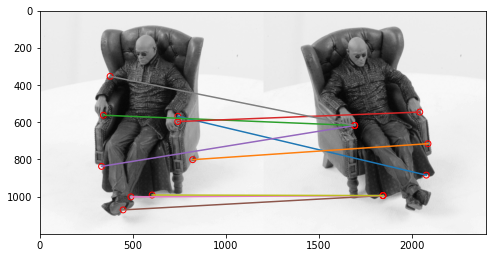

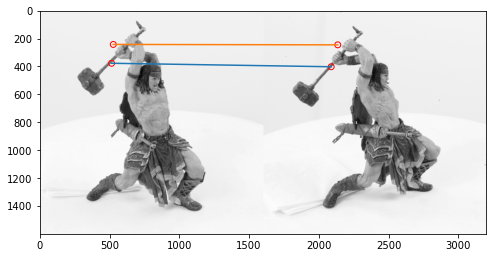

In [22]:
# plot matching result
def show_matching_result(img1, img2, matching):
    fig = plt.figure(figsize=(8, 8))
    plt.imshow(np.hstack((img1, img2)), cmap='gray') # two dino images are of different sizes, resize one before use
    for p1, p2 in matching:
        plt.scatter(p1[0], p1[1], s=35, edgecolors='r', facecolors='none')
        plt.scatter(p2[0] + img1.shape[1], p2[1], s=35, edgecolors='r', facecolors='none')
        plt.plot([p1[0], p2[0] + img1.shape[1]], [p1[1], p2[1]])
    plt.savefig('dino_matching.png')
    plt.show()

print("Number of Corners:", nCorners)
show_matching_result(imgs_mat[0], imgs_mat[1], matching_mat)
show_matching_result(imgs_war[0], imgs_war[1], matching_war)

## Problem 4: Epipolar Geometry [34 points]

As shown in Problem 2, the naive mathing algorithm is simple. The weakness of this method comes from the high matching complexity. In this problem, we will explore how to visualize epipolar geometry constraint in the form of epipolar lines. Although it is outside the scope of this assignment, we can further use this constraint to rectify the images to build a better matching algorithm.

### Problem 4.1: Fundamental matrix [10 points]
Complete the <code>compute_fundamental</code> function below using the 8-point algorithm described in lecture. Note that the normalization of the corner points is handled in the <code>fundamental_matrix</code> function. <br/>
Hint: When you try to find the non-trival solution to an linear equation system **Af=0**, you can use singular value decomposition (SVD) method:SVD(__A__)=USV<sup>T</sup>. And **f** is given by the singular vector corresponding to the smallest singular value, which is the last column of V.

In [23]:
import numpy as np
from imageio import imread
import matplotlib.pyplot as plt
from scipy.io import loadmat
from numpy.linalg import svd

def compute_fundamental(x1, x2):
    """ Computes the fundamental matrix from corresponding points 
        (x1,x2 3*n arrays) using the 8 point algorithm.
        
        Construct the A matrix according to lecture
        and solve the system of equations for the entries of the fundamental matrix.

        Returns:
        Fundamental Matrix (3x3)
    """
    
    """ ==========
    YOUR CODE HERE
    ========== """
    
    # x1 and x2 are 3x13

    #A should be nx9
    x1 = np.array(x1)
    x2 = np.array(x2)

    x1, x2 = x2, x1

    n = x1.shape[1]

    #print("x1: ")
    #print(x1)

    
    A = np.ones((n,9))

    
    A[:,0] = (x2[0,:])*(x1[0,:]).T  #1x13 after transpose
    A[:,1] = (x2[0,:])*(x1[1,:]).T
    A[:,2] = x2[0,:].T
    A[:,3] = (x2[1,:])*(x1[0,:]).T

    A[:,4] = (x2[1,:])*(x1[1,:]).T
    A[:,5] = x2[1,:].T

    A[:,6] = x1[0,:].T
    A[:,7] = x1[1,:].T

    #print("first column: ")
    #print(A[:,0])
    
    """""
    A[:,0] = (x1[1,:])*(x2[1,:])
    A[:,1] = (x1[1,:])*(x2[2,:])
    A[:,2] = x1[1,:]
    A[:,3] = (x1[2,:])*(x2[1,:])

    A[:,4] = (x1[2,:])*(x2[2,:])
    A[:,5] = x1[2,:]

    A[:,6] = x2[1,:]
    A[:,7] = x2[2,:]
    """

    
    
    U,S,V = np.linalg.svd(A)

    #print("V: ")
    #print(V.shape)


    #based on what some guy on discord said:
    #F = V[:,-1]
    F = np.reshape(V[8,:],(3,3))

    # constrain F
    # make rank 2 by zeroing out last singular value
    U,S,V = np.linalg.svd(F)
    S[2] = 0
    F = np.dot(U,np.dot(np.diag(S),V))
    
    return F/F[2,2]

In [24]:
def fundamental_matrix(x1,x2):
    # Normalization of the corner points is handled here
    n = x1.shape[1]
    if x2.shape[1] != n:
        raise ValueError("Number of points don't match.")

    # normalize image coordinates
    x1 = x1 / x1[2]
    mean_1 = np.mean(x1[:2],axis=1)
    S1 = np.sqrt(2) / np.std(x1[:2])
    T1 = np.array([[S1,0,-S1*mean_1[0]],[0,S1,-S1*mean_1[1]],[0,0,1]])
    x1 = np.dot(T1,x1)
    
    x2 = x2 / x2[2]
    mean_2 = np.mean(x2[:2],axis=1)
    S2 = np.sqrt(2) / np.std(x2[:2])
    T2 = np.array([[S2,0,-S2*mean_2[0]],[0,S2,-S2*mean_2[1]],[0,0,1]])
    x2 = np.dot(T2,x2)

    # compute F with the normalized coordinates
    F = compute_fundamental(x1,x2)

    # reverse normalization
    F = np.dot(T1.T,np.dot(F,T2))

    return F/F[2,2]

In [25]:
# Here is the code for you to test your implementation
cor1 = np.load("./p4/"+'dino'+"/cor1.npy")
cor2 = np.load("./p4/"+'dino'+"/cor2.npy")
print(fundamental_matrix(cor1,cor2))
# should print 
#[[ 4.00502510e-07  3.09619039e-06 -2.86966053e-03]
#[-2.69900666e-06 -1.00972419e-08  6.70452915e-03]
#[ 1.37819769e-03 -7.29675791e-03  1.00000000e+00]]

[[ 4.00502510e-07  3.09619039e-06 -2.86966053e-03]
 [-2.69900666e-06 -1.00972419e-08  6.70452915e-03]
 [ 1.37819769e-03 -7.29675791e-03  1.00000000e+00]]


### Problem 4.2: Epipoles [8 points]
In this part, you are supposed to complete the function <code>compute_epipole</code> to calculate the epipoles for a given fundamental matrix.

In [26]:
def compute_epipole(F):
    """
    This function computes the epipoles for a given fundamental matrix.
    
    input:
      F --> fundamental matrix
    output:
      e1 --> corresponding epipole in image 1
      e2 --> epipole in image2
    """

    """ ==========
    YOUR CODE HERE
    ========== """

    U2,S2,V2 = np.linalg.svd(F)
    U1,S1,V1 = np.linalg.svd(F.T)


    #how do we compute the left and right null spaces of F?
    #how do we find the columns corresponding to singular values equal to zero?

    
    e1 = V1[-1,:]
    e1 = e1/e1[2] 
    e2 = V2[-1,:]
    e2 = e2/e2[2]

    return e1,e2

In [27]:
# Here is the code for you to test your implementation
F_test = np.array([[1, 2, 1], [6, 5, 4], [9, 8, 1]])
print(compute_epipole(F_test))
# should print 
#(array([-65.3659783 ,  15.85984739,   1.        ]), 
#array([-41.86658577,  46.87378417,   1.        ]))

(array([-65.3659783 ,  15.85984739,   1.        ]), array([-41.86658577,  46.87378417,   1.        ]))


### Problem 4.3: Plot Epipolar Lines [16 points]

Using this fundamental matrix, plot the epipolar lines in both images for each image pair. For this part, you will want to complete the function <code>plot_epipolar_lines</code>. Show your result for matrix and warrior as exemplified by the figure below. 

![Dino Epipolar](fig/dinoEpi1.png)
![Dino Epipolar](fig/dinoEpi2.png)



In [28]:
def plot_epipolar_lines(img1, img2, cor1, cor2):
    """Plot epipolar lines on image given image, corners

    Args:
        img1: Image 1.
        img2: Image 2.
        cor1: Corners in homogeneous image coordinate in image 1 (3xn)
        cor2: Corners in homogeneous image coordinate in image 2 (3xn)

    """    
    assert cor1.shape[0] == 3
    assert cor2.shape[0] == 3
    assert cor1.shape == cor2.shape
    
    F = fundamental_matrix(cor1, cor2)
    e1, e2 = compute_epipole(F)

    """ ==========
    YOUR CODE HERE
    ========== """
    
    cor1 = np.array(cor1) #3x11, 3x13
    cor2 = np.array(cor2)
    
    #print(img1.shape) #1500x2000x3

    t_cor1 = cor1.T #11x3, 13x3
    t_cor2 = cor2.T

    #print(len(img1)) #1500, 

    x_trial = np.arange(0, len(img1[0]), 1)

    fig = plt.figure(figsize=(8,8))
    plt.imshow(img1)

    #print(len(t_cor1))

    for i in range(0, len(t_cor1)):
        
        curr_cor1 = t_cor1[i]
        line_cor1 = np.dot(F,t_cor2[i]) 

        y = ((-(line_cor1[0] * x_trial)) - line_cor1[2])/(line_cor1[1])         
        
        #print(curr_cor1)
        plt.plot(x_trial,y)
    plt.scatter(t_cor1[:,0], t_cor1[:,1], s=50)



    fig = plt.figure(figsize=(8,8))
    plt.imshow(img2)

    for i in range(0, len(cor2[0])):

        curr_cor2 = t_cor2[i]
        
        line_cor2 = np.dot(F.T,t_cor1[i])
        

        y = ((-(line_cor2[0] * x_trial)) - line_cor2[2])/(line_cor2[1]) 

        #print(curr_cor2)
        plt.plot(x_trial,y)
    plt.scatter(t_cor2[:,0], t_cor2[:,1], s=50)
    
    

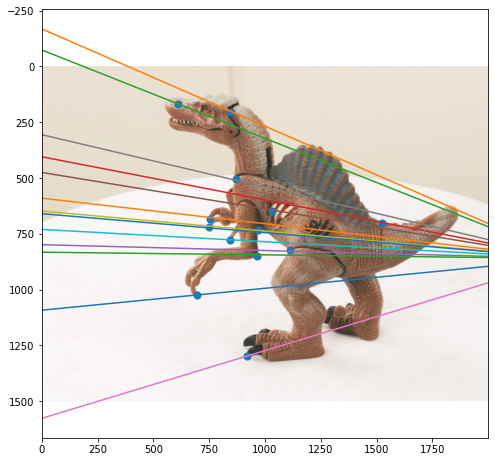

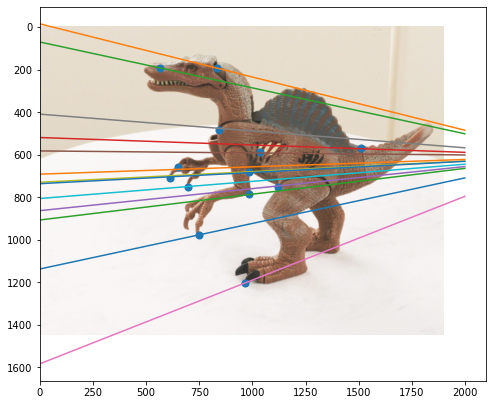

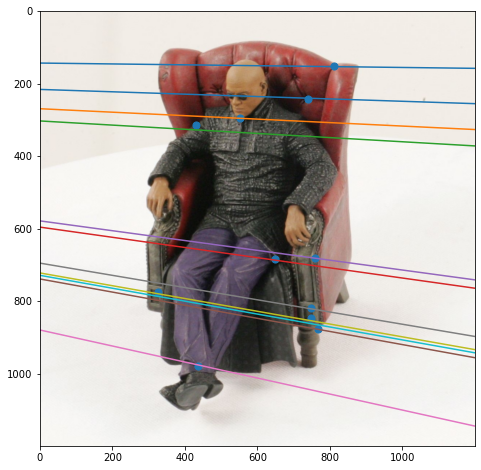

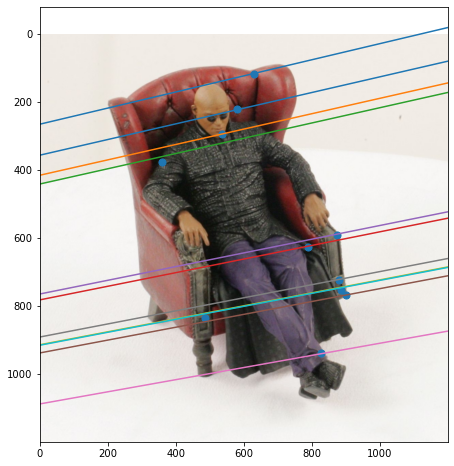

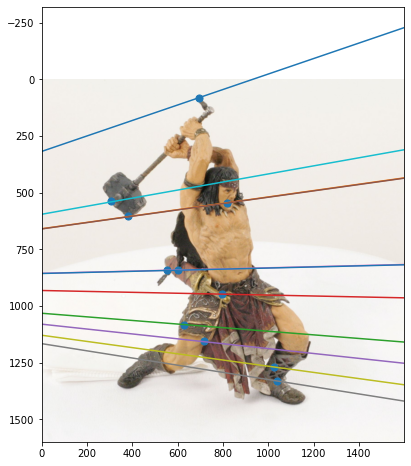

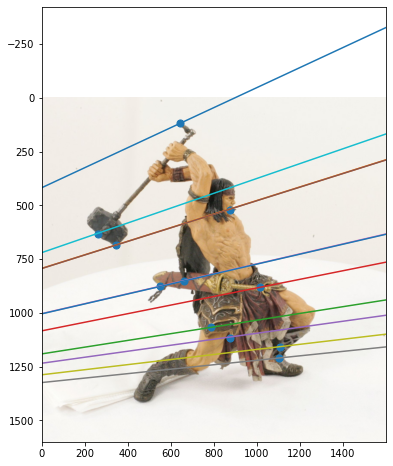

In [29]:
# replace images and corners with those of matrix and warrior
imgids = ["dino", "matrix", "warrior"]
for imgid in imgids:
    I1 = imageio.imread("./p4/"+imgid+"/"+imgid+"0.png")
    I2 = imageio.imread("./p4/"+imgid+"/"+imgid+"1.png")
    cor1 = np.load("./p4/"+imgid+"/cor1.npy")
    cor2 = np.load("./p4/"+imgid+"/cor2.npy")
    plot_epipolar_lines(I1,I2,cor1,cor2)
